In [1]:
import pandas as pd
import numpy as np
import pyunpack
import math
import json

from data.data_download import Config, download_electricity
from data_formatters.electricity import ElectricityFormatter
from data_formatters.base import DataTypes, InputTypes

from data.custom_dataset import TFTDataset
from models import GatedLinearUnit
from models import GateAddNormNetwork
from models import GatedResidualNetwork 
from models import ScaledDotProductAttention
from models import InterpretableMultiHeadAttention
from models import VariableSelectionNetwork

from quantile_loss import QuantileLossCalculator
from quantile_loss import NormalizedQuantileLossCalculator

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from argparse import ArgumentParser

import matplotlib.pyplot as plt

## Download Data

In [2]:
config = Config('data','data/electricity.csv')

In [3]:
#download_electricity(config)

## Creating Datasets

In [4]:
electricity = pd.read_csv('data/electricity.csv', index_col = 0)
data_formatter = ElectricityFormatter()
train, valid, test = data_formatter.split_data(electricity)

/usr/local/venv/3.6.9/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Formatting train-valid-test splits.
Setting scalers with training data...


In [5]:
train.shape, valid.shape, test.shape

((1923536, 13), (274536, 13), (123984, 13))

In [63]:
train.head(10)

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
17544,-0.127174,26304.0,1096,0,2014-01-01 00:00:00,MT_001,-1.661325,1,-0.499719,1,-1.731721,2,0
17545,-0.050713,26305.0,1096,0,2014-01-01 01:00:00,MT_001,-1.516862,1,-0.499719,1,-1.731062,2,1
17546,-0.050713,26306.0,1096,0,2014-01-01 02:00:00,MT_001,-1.372399,1,-0.499719,1,-1.730403,2,2
17547,-0.050713,26307.0,1096,0,2014-01-01 03:00:00,MT_001,-1.227936,1,-0.499719,1,-1.729744,2,3
17548,-0.127174,26308.0,1096,0,2014-01-01 04:00:00,MT_001,-1.083473,1,-0.499719,1,-1.729085,2,4
17549,-0.127174,26309.0,1096,0,2014-01-01 05:00:00,MT_001,-0.939010,1,-0.499719,1,-1.728426,2,5
17550,0.025749,26310.0,1096,0,2014-01-01 06:00:00,MT_001,-0.794547,1,-0.499719,1,-1.727767,2,6
17551,-0.050713,26311.0,1096,0,2014-01-01 07:00:00,MT_001,-0.650084,1,-0.499719,1,-1.727108,2,7
17552,-0.433022,26312.0,1096,0,2014-01-01 08:00:00,MT_001,-0.505621,1,-0.499719,1,-1.726449,2,8
17553,-0.662407,26313.0,1096,0,2014-01-01 09:00:00,MT_001,-0.361158,1,-0.499719,1,-1.725790,2,9


In [6]:
train.days_from_start.value_counts().to_frame().reset_index().sort_values(by=['index'])

,index,days_from_start
218,1096,8400
206,1097,8400
208,1098,8400
209,1099,8400
210,1100,8400
...,...,...
17,1310,8856
18,1311,8856
20,1312,8856
2,1313,8856


In [7]:
valid.days_from_start.value_counts().to_frame().reset_index().sort_values(by=['index'])

,index,days_from_start
30,1308,8856
2,1309,8856
3,1310,8856
4,1311,8856
5,1312,8856
6,1313,8856
7,1314,8856
8,1315,8856
9,1316,8856
10,1317,8856


In [8]:
test.days_from_start.value_counts().to_frame().reset_index().sort_values(by=['index'])

,index,days_from_start
11,1332,8856
10,1333,8856
9,1334,8856
8,1335,8856
7,1336,8856
6,1337,8856
5,1338,8856
4,1339,8856
3,1340,8856
2,1341,8856


### Reviewing Test dataset error

In [9]:
test = test.reset_index(drop=True)
test

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,3.313606,31968.0,1332,0,2014-08-25 00:00:00,MT_001,-1.661325,25,-1.503741,8,2.001283,0,0
1,3.160683,31969.0,1332,0,2014-08-25 01:00:00,MT_001,-1.516862,25,-1.503741,8,2.001942,0,1
2,3.160683,31970.0,1332,0,2014-08-25 02:00:00,MT_001,-1.372399,25,-1.503741,8,2.002601,0,2
3,3.313606,31971.0,1332,0,2014-08-25 03:00:00,MT_001,-1.227936,25,-1.503741,8,2.003260,0,3
4,3.237144,31972.0,1332,0,2014-08-25 04:00:00,MT_001,-1.083473,25,-1.503741,8,2.003920,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123979,0.929284,32299.0,1345,368,2014-09-07 19:00:00,MT_370,1.083473,7,1.508326,9,2.219437,6,19
123980,0.579135,32300.0,1345,368,2014-09-07 20:00:00,MT_370,1.227936,7,1.508326,9,2.220096,6,20
123981,0.761504,32301.0,1345,368,2014-09-07 21:00:00,MT_370,1.372399,7,1.508326,9,2.220755,6,21
123982,0.666672,32302.0,1345,368,2014-09-07 22:00:00,MT_370,1.516862,7,1.508326,9,2.221415,6,22


In [10]:
test[test.categorical_id == 0]

,power_usage,t,days_from_start,categorical_id,date,id,hour,day,day_of_week,month,hours_from_start,categorical_day_of_week,categorical_hour
0,3.313606,31968.0,1332,0,2014-08-25 00:00:00,MT_001,-1.661325,25,-1.503741,8,2.001283,0,0
1,3.160683,31969.0,1332,0,2014-08-25 01:00:00,MT_001,-1.516862,25,-1.503741,8,2.001942,0,1
2,3.160683,31970.0,1332,0,2014-08-25 02:00:00,MT_001,-1.372399,25,-1.503741,8,2.002601,0,2
3,3.313606,31971.0,1332,0,2014-08-25 03:00:00,MT_001,-1.227936,25,-1.503741,8,2.003260,0,3
4,3.237144,31972.0,1332,0,2014-08-25 04:00:00,MT_001,-1.083473,25,-1.503741,8,2.003920,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,3.237144,32299.0,1345,0,2014-09-07 19:00:00,MT_001,1.083473,7,1.508326,9,2.219437,6,19
332,0.025749,32300.0,1345,0,2014-09-07 20:00:00,MT_001,1.227936,7,1.508326,9,2.220096,6,20
333,1.325600,32301.0,1345,0,2014-09-07 21:00:00,MT_001,1.372399,7,1.508326,9,2.220755,6,21
334,3.237144,32302.0,1345,0,2014-09-07 22:00:00,MT_001,1.516862,7,1.508326,9,2.221415,6,22


In [11]:
test.groupby(['categorical_id']).apply(lambda x: x.shape[0]).mean()

336.0

In [12]:
g = test.groupby(['categorical_id'])

In [13]:
data_formatter.get_time_steps()

192

In [14]:
df_index_abs = g[['categorical_id']].transform(lambda x: x.index+data_formatter.get_time_steps()) \
                        .reset_index() \
                        .rename(columns={'index':'init_abs',
                                         'categorical_id':'end_abs'})
df_index_abs

,init_abs,end_abs
0,0,192
1,1,193
2,2,194
3,3,195
4,4,196
...,...,...
123979,123979,124171
123980,123980,124172
123981,123981,124173
123982,123982,124174


In [15]:
df_index_rel_init = g[['categorical_id']].transform(lambda x: x.reset_index(drop=True).index) \
                        .rename(columns={'categorical_id':'init_rel'})
df_index_rel_init

,init_rel
0,0
1,1
2,2
3,3
4,4
...,...
123979,331
123980,332
123981,333
123982,334


In [16]:
df_index_rel_end = g[['categorical_id']].transform(lambda x: x.reset_index(drop=True).index+data_formatter.get_time_steps()) \
                .rename(columns={'categorical_id':'end_rel'})
df_index_rel_end

,end_rel
0,192
1,193
2,194
3,195
4,196
...,...
123979,523
123980,524
123981,525
123982,526


In [17]:
336 - 192 + 1

145

In [18]:
df_total_count = g[['categorical_id']].transform(lambda x: x.shape[0] - data_formatter.get_time_steps() + 1) \
                .rename(columns = {'categorical_id':'group_count'})
df_total_count

,group_count
0,145
1,145
2,145
3,145
4,145
...,...
123979,145
123980,145
123981,145
123982,145


In [19]:
new_test = pd.concat([df_index_abs, 
                       df_index_rel_init,
                       df_index_rel_end,
                       test[['id']], 
                       df_total_count], axis = 1).reset_index(drop = True)
new_test

,init_abs,end_abs,init_rel,end_rel,id,group_count
0,0,192,0,192,MT_001,145
1,1,193,1,193,MT_001,145
2,2,194,2,194,MT_001,145
3,3,195,3,195,MT_001,145
4,4,196,4,196,MT_001,145
...,...,...,...,...,...,...
123979,123979,124171,331,523,MT_370,145
123980,123980,124172,332,524,MT_370,145
123981,123981,124173,333,525,MT_370,145
123982,123982,124174,334,526,MT_370,145


In [20]:
new_test[new_test.end_rel < test.groupby(['categorical_id']).apply(lambda x: x.shape[0]).mean()].reset_index()

,index,init_abs,end_abs,init_rel,end_rel,id,group_count
0,0,0,192,0,192,MT_001,145
1,1,1,193,1,193,MT_001,145
2,2,2,194,2,194,MT_001,145
3,3,3,195,3,195,MT_001,145
4,4,4,196,4,196,MT_001,145
...,...,...,...,...,...,...,...
53131,123787,123787,123979,139,331,MT_370,145
53132,123788,123788,123980,140,332,MT_370,145
53133,123789,123789,123981,141,333,MT_370,145
53134,123790,123790,123982,142,334,MT_370,145


## Loading Datasets

In [21]:
train_dataset = TFTDataset(train)
valid_dataset = TFTDataset(valid)
test_dataset = TFTDataset(test)

In [22]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(1841286, 203688, 53136)

In [23]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(1841286, 203688, 53136)

In [26]:
test_dataset[0][0].shape, test_dataset[0][1].shape, test_dataset[0][2].shape

((192, 5), (24, 1), (24, 1))

## Temporal Fusion Transformer

In [27]:
class TemporalFusionTransformer(pl.LightningModule):
    def __init__(self, hparams):
        super(TemporalFusionTransformer, self).__init__()
        
        self.hparams = hparams
        
        self.name = self.__class__.__name__

        # Data parameters
        self.time_steps = int(hparams.total_time_steps)#int(params['total_time_steps'])
        self.input_size = int(hparams.input_size)#int(params['input_size'])
        self.output_size = int(hparams.output_size)#int(params['output_size'])
        self.category_counts = json.loads(str(hparams.category_counts))#json.loads(str(params['category_counts']))
        self.num_categorical_variables = len(self.category_counts)
        self.num_regular_variables = self.input_size - self.num_categorical_variables
        self.n_multiprocessing_workers = int(hparams.multiprocessing_workers) #int(params['multiprocessing_workers'])

        # Relevant indices for TFT
        self._input_obs_loc = json.loads(str(hparams.input_obs_loc))#json.loads(str(params['input_obs_loc']))
        self._static_input_loc = json.loads(str(hparams.static_input_loc))#json.loads(str(params['static_input_loc']))
        self._known_regular_input_idx = json.loads(str(hparams.known_regular_inputs))#json.loads(str(params['known_regular_inputs']))
        self._known_categorical_input_idx = json.loads(str(hparams.known_categorical_inputs))#json.loads(str(params['known_categorical_inputs']))
        
        self.num_non_static_historical_inputs = self.get_historical_num_inputs()
        self.num_non_static_future_inputs = self.get_future_num_inputs()
        
        self.column_definition = [
                                  ('id', DataTypes.REAL_VALUED, InputTypes.ID),
                                  ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.TIME),
                                  ('power_usage', DataTypes.REAL_VALUED, InputTypes.TARGET),
                                  ('hour', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('day_of_week', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('hours_from_start', DataTypes.REAL_VALUED, InputTypes.KNOWN_INPUT),
                                  ('categorical_id', DataTypes.CATEGORICAL, InputTypes.STATIC_INPUT),
                                ]

        # Network params
        self.quantiles = [0.1, 0.5, 0.9]
#         self.use_cudnn = use_cudnn  # Whether to use GPU optimised LSTM
        self.hidden_layer_size = int(hparams.hidden_layer_size)#int(params['hidden_layer_size'])
        self.dropout_rate = float(hparams.dropout_rate)#float(params['dropout_rate'])
        self.max_gradient_norm = float(hparams.max_gradient_norm)#float(params['max_gradient_norm'])
        self.learning_rate = float(hparams.learning_rate)#float(params['learning_rate'])
        self.minibatch_size = int(hparams.minibatch_size)#int(params['minibatch_size'])
        self.num_epochs = int(hparams.num_epochs)#int(params['num_epochs'])
        self.early_stopping_patience = int(hparams.early_stopping_patience)#int(params['early_stopping_patience'])

        self.num_encoder_steps = int(hparams.num_encoder_steps)#int(params['num_encoder_steps'])
        self.num_stacks = int(hparams.stack_size)#int(params['stack_size'])
        self.num_heads = int(hparams.num_heads)#int(params['num_heads'])

        # Serialisation options
#         self._temp_folder = os.path.join(params['model_folder'], 'tmp')
#         self.reset_temp_folder()

        # Extra components to store Tensorflow nodes for attention computations
        self._input_placeholder = None
        self._attention_components = None
        self._prediction_parts = None

        print('*** {} params ***'.format(self.name))
        for k in vars(hparams):
            print('# {} = {}'.format(k, vars(hparams)[k]))
            
        self.train_criterion = QuantileLossCalculator(self.quantiles, self.output_size)
        self.test_criterion = NormalizedQuantileLossCalculator(self.quantiles, self.output_size)

        # Build model
        ## Build embeddings
        self.build_embeddings()
        
        ## Build Static Contex Networks
        self.build_static_context_networks()
        
        ## Building Variable Selection Networks
        self.build_variable_selection_networks()
        
        ## Build Lstm
        self.build_lstm()
        
        ## Build GLU for after lstm encoder decoder and layernorm
        self.build_post_lstm_gate_add_norm()
        
        ## Build Static Enrichment Layer
        self.build_static_enrichment()
        
        ## Building decoder multihead attention
        self.build_temporal_self_attention()
        
        ## Building positionwise decoder
        self.build_position_wise_feed_forward()
        
        ## Build output feed forward
        self.build_output_feed_forward()
        
        ## Initializing remaining weights
        self.init_weights()
        
    def init_weights(self):
        for name, p in self.named_parameters():
            if ('lstm' in name and 'ih' in name) and 'bias' not in name:
                #print(name)
                #print(p.shape)
                torch.nn.init.xavier_uniform_(p)
#                 torch.nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='sigmoid')
            elif ('lstm' in name and 'hh' in name) and 'bias' not in name:
        
                 torch.nn.init.orthogonal_(p)
            
            elif 'lstm' in name and 'bias' in name:
                #print(name)
                #print(p.shape)
                torch.nn.init.zeros_(p)
        
    def get_historical_num_inputs(self):
        
        obs_inputs = [i for i in self._input_obs_loc]
        
        known_regular_inputs = [i for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
            
        known_categorical_inputs = [i for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]
        
        wired_embeddings = [i for i in range(self.num_categorical_variables)
                            if i not in self._known_categorical_input_idx 
                            and i not in self._input_obs_loc]

        unknown_inputs = [i for i in range(self.num_regular_variables)
                          if i not in self._known_regular_input_idx
                          and i not in self._input_obs_loc]

        return len(obs_inputs+known_regular_inputs+known_categorical_inputs+wired_embeddings+unknown_inputs)
    
    def get_future_num_inputs(self):
            
        known_regular_inputs = [i for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
            
        known_categorical_inputs = [i for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]

        return len(known_regular_inputs + known_categorical_inputs)
    
    def build_embeddings(self):
        self.categorical_var_embeddings = nn.ModuleList([nn.Embedding(self.category_counts[i], 
                                                                      self.hidden_layer_size) 
                                                     for i in range(self.num_categorical_variables)])

        self.regular_var_embeddings = nn.ModuleList([nn.Linear(1, 
                                                              self.hidden_layer_size) 
                                                  for i in range(self.num_regular_variables)])

    def build_variable_selection_networks(self):
        
        self.static_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                   input_size = self.hidden_layer_size * len(self._static_input_loc),
                                                   output_size = len(self._static_input_loc),
                                                   dropout_rate = self.dropout_rate)
        
        self.temporal_historical_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                                input_size = self.hidden_layer_size *
                                                                        self.num_non_static_historical_inputs,
                                                                output_size = self.num_non_static_historical_inputs,
                                                                dropout_rate = self.dropout_rate,
                                                                additional_context=self.hidden_layer_size)
        
        self.temporal_future_vsn = VariableSelectionNetwork(hidden_layer_size = self.hidden_layer_size,
                                                            input_size = self.hidden_layer_size *
                                                                        self.num_non_static_future_inputs,
                                                            output_size = self.num_non_static_future_inputs,
                                                            dropout_rate = self.dropout_rate,
                                                            additional_context=self.hidden_layer_size)
        
    def build_static_context_networks(self):
        
        self.static_context_variable_selection_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                                          dropout_rate=self.dropout_rate)
        
        self.static_context_enrichment_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                              dropout_rate=self.dropout_rate)

        self.static_context_state_h_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                           dropout_rate=self.dropout_rate)
        
        self.static_context_state_c_grn = GatedResidualNetwork(self.hidden_layer_size,
                                                           dropout_rate=self.dropout_rate)
        
    def build_lstm(self):
        self.historical_lstm = nn.LSTM(input_size = self.hidden_layer_size,
                                       hidden_size = self.hidden_layer_size,
                                       batch_first = True)
        self.future_lstm = nn.LSTM(input_size = self.hidden_layer_size,
                                   hidden_size = self.hidden_layer_size,
                                   batch_first = True)
        
    def build_post_lstm_gate_add_norm(self):
        self.post_seq_encoder_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                                 self.hidden_layer_size,
                                                                 self.dropout_rate,
                                                                 activation = None)
        
    def build_static_enrichment(self):
        self.static_enrichment = GatedResidualNetwork(self.hidden_layer_size,
                                                      dropout_rate = self.dropout_rate,
                                                      additional_context=self.hidden_layer_size)
        
    def build_temporal_self_attention(self):
        self.self_attn_layer = InterpretableMultiHeadAttention(n_head = self.num_heads, 
                                                               d_model = self.hidden_layer_size,
                                                               dropout = self.dropout_rate)
        
        self.post_attn_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                           self.hidden_layer_size,
                                                           self.dropout_rate,
                                                           activation = None)
        
    def build_position_wise_feed_forward(self):
        self.GRN_positionwise = GatedResidualNetwork(self.hidden_layer_size,
                                                     dropout_rate = self.dropout_rate)
        
        self.post_tfd_gate_add_norm = GateAddNormNetwork(self.hidden_layer_size,
                                                         self.hidden_layer_size,
                                                         self.dropout_rate,
                                                         activation = None)
        
    def build_output_feed_forward(self):
        self.output_feed_forward = torch.nn.Linear(self.hidden_layer_size, 
                                                   self.output_size * len(self.quantiles))
         
    def get_decoder_mask(self, self_attn_inputs):
        """Returns causal mask to apply for self-attention layer.
        Args:
        self_attn_inputs: Inputs to self attention layer to determine mask shape
        """
        len_s = self_attn_inputs.shape[1]
        bs = self_attn_inputs.shape[0]
        mask = torch.cumsum(torch.eye(len_s), 0)
        mask = mask.repeat(bs,1,1).to(torch.float32)

        return mask.to(DEVICE)
    
    def get_tft_embeddings(self, regular_inputs, categorical_inputs):
        # Static input
        if self._static_input_loc:
            static_regular_inputs = [self.regular_var_embeddings[i](regular_inputs[:, 0, i:i + 1]) 
                                    for i in range(self.num_regular_variables)
                                    if i in self._static_input_loc]
            #print('static_regular_inputs')
            #print([print(emb.shape) for emb in static_regular_inputs])
            
            static_categorical_inputs = [self.categorical_var_embeddings[i](categorical_inputs[Ellipsis, i])[:,0,:] 
                                         for i in range(self.num_categorical_variables)
                                         if i + self.num_regular_variables in self._static_input_loc]
            #print('static_categorical_inputs')
            #print([print(emb.shape) for emb in static_categorical_inputs])
            static_inputs = torch.stack(static_regular_inputs + static_categorical_inputs, axis = 1)
        else:
            static_inputs = None
            
        # Target input
        obs_inputs = torch.stack([self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                                     for i in self._input_obs_loc], axis=-1)
        
        # Observed (a prioir unknown) inputs
        wired_embeddings = []
        for i in range(self.num_categorical_variables):
            if i not in self._known_categorical_input_idx \
            and i not in self._input_obs_loc:
                e = self.categorical_var_embeddings[i](categorical_inputs[:, :, i])
                wired_embeddings.append(e)

        unknown_inputs = []
        for i in range(self.num_regular_variables):
            if i not in self._known_regular_input_idx \
            and i not in self._input_obs_loc:
                e = self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                unknown_inputs.append(e)
                
        if unknown_inputs + wired_embeddings:
            unknown_inputs = torch.stack(unknown_inputs + wired_embeddings, axis=-1)
        else:
            unknown_inputs = None
            
        # A priori known inputs
        known_regular_inputs = [self.regular_var_embeddings[i](regular_inputs[Ellipsis, i:i + 1])
                                for i in self._known_regular_input_idx
                                if i not in self._static_input_loc]
        #print('known_regular_inputs')
        #print([print(emb.shape) for emb in known_regular_inputs])
        
        known_categorical_inputs = [self.categorical_var_embeddings[i](categorical_inputs[Ellipsis, i])
                                    for i in self._known_categorical_input_idx
                                    if i + self.num_regular_variables not in self._static_input_loc]
       #print('known_categorical_inputs')
       #print([print(emb.shape) for emb in known_categorical_inputs])

        known_combined_layer = torch.stack(known_regular_inputs + known_categorical_inputs, axis=-1)
        
        return unknown_inputs, known_combined_layer, obs_inputs, static_inputs
        
    def forward(self, all_inputs):

        regular_inputs = all_inputs[:, :, :self.num_regular_variables].to(torch.float)
        #print('regular_inputs')
        #print(regular_inputs.shape)
        categorical_inputs = all_inputs[:, :, self.num_regular_variables:].to(torch.long)
        #print('categorical_inputs')
        #print(categorical_inputs.shape)
        
        unknown_inputs, known_combined_layer, obs_inputs, static_inputs \
            = self.get_tft_embeddings(regular_inputs, categorical_inputs)
        
        # Isolate known and observed historical inputs.
        if unknown_inputs is not None:
              historical_inputs = torch.cat([
                  unknown_inputs[:, :self.num_encoder_steps, :],
                  known_combined_layer[:, :self.num_encoder_steps, :],
                  obs_inputs[:, :self.num_encoder_steps, :]
              ], axis=-1)
        else:
              historical_inputs = torch.cat([
                  known_combined_layer[:, :self.num_encoder_steps, :],
                  obs_inputs[:, :self.num_encoder_steps, :]
              ], axis=-1)
                
        #print('historical_inputs')
        #print(historical_inputs.shape)
        
        # Isolate only known future inputs.
        future_inputs = known_combined_layer[:, self.num_encoder_steps:, :]
        #print('future_inputs')
        #print(future_inputs.shape)
              
        #print('static_inputs')
        #print(static_inputs.shape)
        
        static_encoder, sparse_weights = self.static_vsn(static_inputs)
        
        #print('static_encoder')
        #print(static_encoder.shape)
        
        #print('sparse_weights')
        #print(sparse_weights.shape)
        
        static_context_variable_selection = self.static_context_variable_selection_grn(static_encoder)
        #print('static_context_variable_selection')
        #print(static_context_variable_selection.shape)
        static_context_enrichment = self.static_context_enrichment_grn(static_encoder)
        #print('static_context_enrichment')
        #print(static_context_enrichment.shape)
        static_context_state_h = self.static_context_state_h_grn(static_encoder)
        #print('static_context_state_h')
        #print(static_context_state_h.shape)
        static_context_state_c = self.static_context_state_c_grn(static_encoder)
        #print('static_context_state_c')
        #print(static_context_state_c.shape)
        
        historical_features, historical_flags \
        = self.temporal_historical_vsn((historical_inputs,
                                        static_context_variable_selection))
        #print('historical_features')
        #print(historical_features.shape)
        #print('historical_flags')
        #print(historical_flags.shape)
        
        future_features, future_flags \
        = self.temporal_future_vsn((future_inputs,
                                    static_context_variable_selection))
        #print('future_features')
        #print(future_features.shape)
        #print('future_flags')
        #print(future_flags.shape)
        
        history_lstm, (state_h, state_c) \
        = self.historical_lstm(historical_features,
                               (static_context_state_h.unsqueeze(0),
                                static_context_state_c.unsqueeze(0)))
        #print('history_lstm')
        #print(history_lstm.shape)
        #print('state_h')
        #print(state_h.shape)
        #print('state_c')
        #print(state_c.shape)
        
        future_lstm, _ = self.future_lstm(future_features,
                                          (state_h,
                                           state_c))
        #print('future_lstm')
        #print(future_lstm.shape)
        
        # Apply gated skip connection
        input_embeddings = torch.cat((historical_features, future_features), axis=1)
        #print('input_embeddings')
        #print(input_embeddings.shape) 
        
        lstm_layer = torch.cat((history_lstm, future_lstm), axis=1)
        #print('lstm_layer')
        #print(lstm_layer.shape) 
        
        temporal_feature_layer = self.post_seq_encoder_gate_add_norm(lstm_layer, input_embeddings)
        #print('temporal_feature_layer')
        #print(temporal_feature_layer.shape)  
        
        # Static enrichment layers
        expanded_static_context = static_context_enrichment.unsqueeze(1)
        
        enriched = self.static_enrichment((temporal_feature_layer, expanded_static_context))
        #print('enriched')
        #print(enriched.shape)    
        
        # Decoder self attention
        #self.mask = self.get_decoder_mask(enriched)
        #print('enriched')
        #print(enriched.shape)
        x, self_att = self.self_attn_layer(enriched, 
                                           enriched, 
                                           enriched,
                                           mask = self.get_decoder_mask(enriched))
        #print('x')
        #print(x.shape)
        #print('self_att')
        #print(self_att.shape)
        
        x = self.post_attn_gate_add_norm(x, enriched)
        #print('x')
        #print(x.shape)
        
        # Nonlinear processing on outputs
        decoder = self.GRN_positionwise(x)
        #print('decoder')
        #print(decoder.shape)
        
        # Final skip connection
        transformer_layer = self.post_tfd_gate_add_norm(decoder, temporal_feature_layer)
        #print('transformer_layer')
        #print(transformer_layer.shape)
        
        outputs = self.output_feed_forward(transformer_layer[Ellipsis, self.num_encoder_steps:, :])
        #print('outputs')
        #print(outputs.shape)
        
        #ipdb.set_trace()
        
        return outputs
    
    def loss(self, y_hat, y):
        return self.train_criterion.apply(y_hat, y)
    
    def test_loss(self, y_hat, y):
        return self.test_criterion.apply(y_hat, y, self.quantiles[1])
    
    def training_step(self, batch, batch_nb):
        x, y, _ = batch
        
        x = x.to(torch.float)
        y = y.to(torch.float)
#         print('y')
#         print(y.shape)
        y_hat = self.forward(x)
#         print('y_hat')
#         print(y_hat.shape)
        loss = self.loss(y_hat, torch.cat([y, y, y], dim = -1))
        #print(loss.shape)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_nb):
        x, y, _ = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        #print(y_hat.shape)
        #print(torch.cat([y, y, y], dim = -1).shape)
        loss = self.loss(y_hat, torch.cat([y, y, y], dim = -1))
        #print(loss)
        return {'val_loss': loss}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        # OPTIONAL
        x, y, _ = batch
        x = x.to(torch.float)
        y = y.to(torch.float)
        y_hat = self.forward(x)
        return {'test_loss': self.test_loss(y_hat[Ellipsis, 1], y[Ellipsis, 0])}

    def test_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}
    
    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return [torch.optim.Adam(self.parameters(), lr=self.learning_rate)]
    
    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for name, p in named_parameters:
            if p.grad is not None:
                if (p.requires_grad) and ("bias" not in name):
                    layers.append(name)
                    ave_grads.append(p.grad.abs().mean())
                    self.logger.experiment.add_histogram(tag=name, values=p.grad,
                                                         global_step=self.trainer.global_step)
            else:
                 print('{} - {}'.format(name, p.requires_grad))
            
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads), linewidth=1, color="k" )
        plt.xticks(list(range(0,len(ave_grads), 1)), layers, rotation='vertical')
        plt.xlim(left=0, right=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)
        plt.rcParams["figure.figsize"] = (20, 5)
    
    def on_after_backward(self):
        # example to inspect gradient information in tensorboard
        if self.trainer.global_step % 25 == 0:  
            self.plot_grad_flow(self.named_parameters())
    
    def train_dataloader(self):
        # REQUIRED
        return DataLoader(train_dataset, batch_size = self.minibatch_size, shuffle=False, drop_last=True, num_workers=1)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(valid_dataset, batch_size = self.minibatch_size, shuffle=False, drop_last=True, num_workers=1)
    
    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(test_dataset, batch_size = self.minibatch_size, shuffle=False, drop_last=True, num_workers=1)

In [28]:
import inspect as i
import sys
sys.stdout.write(i.getsource(TemporalFusionTransformer.val_dataloader))

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(valid_dataset, batch_size = self.minibatch_size, shuffle=False, drop_last=True, num_workers=1)


## Training

### Setting Device

In [29]:
DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

### Input Parameters

In [30]:
params = data_formatter.get_experiment_params()

In [31]:
params = data_formatter.get_experiment_params()
params.update(data_formatter.get_default_model_params())

parser = ArgumentParser(add_help=False)

In [32]:
for k in params:
    if type(params[k]) in [int, float]:
        #if k == 'minibatch_size':
        #    parser.add_argument('--{}'.format(k), type=type(params[k]), default = 256)
        #else:
        parser.add_argument('--{}'.format(k), type=type(params[k]), default = params[k])
    else:
        parser.add_argument('--{}'.format(k), type=str, default = str(params[k]))
hparams = parser.parse_known_args()[0]

### Model Instance

In [33]:
tft = TemporalFusionTransformer(hparams)#.to(DEVICE)
tft

*** TemporalFusionTransformer params ***
# total_time_steps = 192
# num_encoder_steps = 168
# num_epochs = 1
# early_stopping_patience = 5
# multiprocessing_workers = 5
# column_definition = [('id', <DataTypes.REAL_VALUED: 0>, <InputTypes.ID: 4>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.TIME: 5>), ('power_usage', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('hour', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('day_of_week', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('hours_from_start', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('categorical_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)]
# input_size = 5
# output_size = 1
# category_counts = [369]
# input_obs_loc = [0]
# static_input_loc = [4]
# known_regular_inputs = [1, 2, 3]
# known_categorical_inputs = [0]
# dropout_rate = 0.1
# hidden_layer_size = 160
# learning_rate = 0.001
# minibatch_size = 64
# max_gradient_norm = 0.01
# num_heads = 4
#

TemporalFusionTransformer(
  (categorical_var_embeddings): ModuleList(
    (0): Embedding(369, 160)
  )
  (regular_var_embeddings): ModuleList(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): Linear(in_features=1, out_features=160, bias=True)
    (2): Linear(in_features=1, out_features=160, bias=True)
    (3): Linear(in_features=1, out_features=160, bias=True)
  )
  (static_context_variable_selection_grn): GatedResidualNetwork(
    (W1): Linear(in_features=160, out_features=160, bias=True)
    (W2): Linear(in_features=160, out_features=160, bias=True)
    (glu_add_norm): GateAddNormNetwork(
      (GLU): GatedLinearUnit(
        (dropout): Dropout(p=0.1, inplace=False)
        (W4): Linear(in_features=160, out_features=160, bias=True)
        (W5): Linear(in_features=160, out_features=160, bias=True)
        (sigmoid): Sigmoid()
      )
      (LayerNorm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
  )
  (static_context_enrichment_grn): GatedResidual

In [34]:
early_stop_callback = EarlyStopping(monitor = 'val_loss',
                                    min_delta = 1e-4,
                                    patience = tft.early_stopping_patience,
                                    verbose=False,
                                    mode='min')

In [39]:
tft.num_epochs

1

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
/usr/local/venv/3.6.9/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/usr/local/venv/3.6.9/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

    | Name                                                               | Type                            | Params
-------------------------------------------------------------------------------------------------------------------
0   | categorical_var_embeddings                                         | ModuleList

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]



Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.034547       	|  0.034547       
on_epoch_start      	|  0.0043451      	|  0.0043451      
get_train_batch     	|  0.0027299      	|  0.78621        
on_batch_start      	|  1.4494e-05     	|  0.0041598      
model_forward       	|  0.98433        	|  282.5          
model_backward      	|  1.4096         	|  404.55         
on_after_backward   	|  0.019513       	|  5.6003         
optimizer_step      	|  0.030398       	|  8.7243         
on_batch_end        	|  0.0030023      	|  0.86166        
on_epoch_end        	|  2.7858e-05     	|  2.7858e-05     
on_train_end        	|  0.0011173      	|  0.0011173      



1

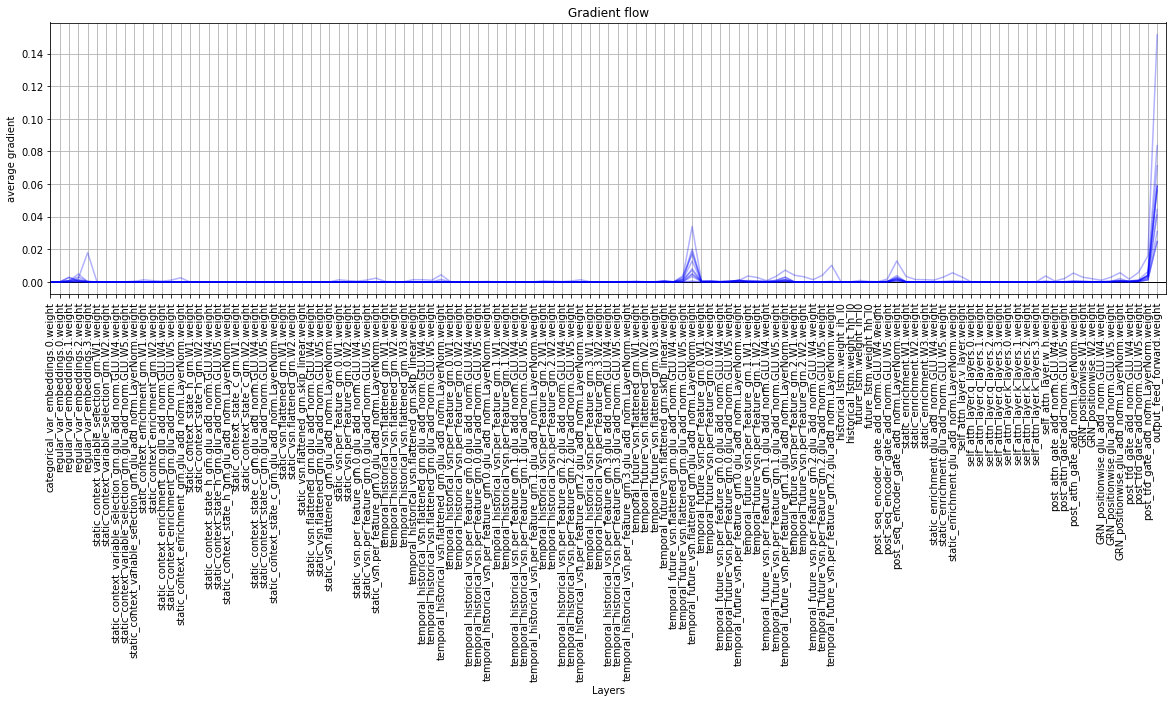

In [40]:
trainer = pl.Trainer(max_nb_epochs = tft.num_epochs,
                     gpus = 0, 
                     track_grad_norm = 2, 
                     gradient_clip_val = tft.max_gradient_norm,
                     early_stop_callback = early_stop_callback,
                     #train_percent_check = 0.01,
                     #val_percent_check = 0.01,
                     #test_percent_check = 0.01,
                     overfit_pct=0.01,
                     #fast_dev_run=True,
                     profiler=True,
                     #print_nan_grads = True,
                     #distributed_backend='dp'
                    )    
trainer.fit(tft)

In [41]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(2.), 'test_loss': tensor(2.)}
--------------------------------------------------------------------------------


### Testing

In [42]:
!pwd

/Users/long/googleDrive/examples/temporal_fusion_transformer_pytorch-master


In [43]:
model = tft.load_from_metrics(
                             weights_path='lightning_logs/version_18/checkpoints/epoch=6.ckpt',
                             tags_csv='lightning_logs/version_18/meta_tags.csv',
                             #on_gpu=True,
                             map_location=None
                            )

FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/version_18/checkpoints/epoch=6.ckpt'

In [44]:
q_risk = NormalizedQuantileLossCalculator([0.1, 0.5, 0.9], 1)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle=False, drop_last=True)

In [45]:
loss = []
batches = 0
for i, (batch, target, _ )in enumerate(test_dataloader):
    if i < 5:
        t = target
        batches += 1
        output = tft(batch)
        loss.append(q_risk.apply(output[Ellipsis, 1], target[Ellipsis, 0], 0.5))
    else:
        break
mean_loss = sum(loss) / batches
mean_loss

tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>)

In [46]:
loss

[tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2., dtype=torch.float64, grad_fn=<DivBackward0>)]

In [47]:
output[Ellipsis, 1:2].shape

torch.Size([64, 24, 1])

In [48]:
t.shape, output.shape

(torch.Size([64, 24, 1]), torch.Size([64, 24, 3]))

## Testing implementation

In [49]:
def get_decoder_mask(self_attn_inputs):
    """Returns causal mask to apply for self-attention layer.
    Args:
    self_attn_inputs: Inputs to self attention layer to determine mask shape
    """
    len_s = self_attn_inputs.shape[1]
    bs = self_attn_inputs.shape[0]
    mask = torch.cumsum(torch.eye(len_s), 0)
    mask = mask.repeat(bs,1,1).to(torch.float32)

    return mask

In [50]:
a = torch.randn((2,6,4))
a

tensor([[[ 2.5366, -1.5383, -0.9419,  1.8133],
         [ 0.9517, -0.3430, -0.1818, -0.1079],
         [ 0.4701, -0.0739,  2.4087, -1.5884],
         [-0.8502, -0.7517, -1.2451,  2.3523],
         [ 0.8525,  1.1830, -0.5179,  1.0509],
         [-0.4935, -1.1348, -0.8439,  0.2082]],

        [[-0.1695,  0.1338,  0.2476, -1.5088],
         [ 0.0792, -0.9831,  0.7189, -0.0851],
         [ 0.6538, -0.8072,  2.6338,  1.5050],
         [-0.7124, -0.3493, -2.0431,  0.1469],
         [ 0.0229, -0.9118,  0.1650,  1.5727],
         [ 0.3949,  0.4539, -0.6489, -2.1227]]])

In [51]:
mask = get_decoder_mask(a)
mask

tensor([[[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]]])

In [52]:
mask.shape

torch.Size([2, 6, 6])

In [53]:
linear = nn.Linear(4, 2, bias = False)

In [54]:
a_lin = linear(a)
a_lin.shape

torch.Size([2, 6, 2])

In [55]:
to_attn = torch.bmm(a_lin, a_lin.permute(0,2,1))

In [56]:
masked_attn = to_attn.masked_fill(mask == 0, -1e9)
masked_attn

tensor([[[ 1.7139e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 3.5750e-01,  8.0249e-02, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [-5.3042e-01, -1.4452e-01,  3.6636e-01, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 3.5511e-01,  8.4029e-02, -1.6931e-01,  9.1034e-02, -1.0000e+09,
          -1.0000e+09],
         [ 1.4365e+00,  2.6169e-01, -2.1809e-01,  2.3110e-01,  1.4578e+00,
          -1.0000e+09],
         [-6.0923e-01, -8.2151e-02, -7.9584e-02, -4.7451e-02, -8.1100e-01,
           5.7213e-01]],

        [[ 4.1505e-01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 1.7711e-01,  8.3675e-02, -1.0000e+09, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [-6.4670e-01, -2.0722e-01,  1.5908e+00, -1.0000e+09, -1.0000e+09,
          -1.0000e+09],
         [ 4.3059e-01,  1.2976e-01, -1.1289e+00,  8.0634e-01, -1.0000e+09,
          -1.0000e+09],
        

In [57]:
softmax = nn.Softmax(dim = 2)

In [58]:
sft_attn = softmax(masked_attn)
sft_attn

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5689, 0.4311, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2031, 0.2988, 0.4980, 0.0000, 0.0000, 0.0000],
         [0.3203, 0.2442, 0.1896, 0.2459, 0.0000, 0.0000],
         [0.3545, 0.1095, 0.0678, 0.1062, 0.3621, 0.0000],
         [0.0978, 0.1657, 0.1661, 0.1716, 0.0800, 0.3188]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5233, 0.4767, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0839, 0.1302, 0.7859, 0.0000, 0.0000, 0.0000],
         [0.2936, 0.2173, 0.0617, 0.4274, 0.0000, 0.0000],
         [0.1542, 0.1776, 0.2948, 0.1483, 0.2250, 0.0000],
         [0.2047, 0.1553, 0.0530, 0.2532, 0.1023, 0.2315]]],
       grad_fn=<SoftmaxBackward>)

In [59]:
torch.bmm(sft_attn, a_lin).shape

torch.Size([2, 6, 2])

In [60]:
scaled_att = ScaledDotProductAttention()

In [61]:
scaled_att(a_lin, a_lin, a_lin, mask = get_decoder_mask(a))

(tensor([[[ 1.1489, -0.6276],
          [ 0.7550, -0.3737],
          [ 0.1035, -0.2597],
          [ 0.3684, -0.2484],
          [ 0.6126, -0.5354],
          [ 0.1763, -0.0178]],
 
         [[-0.3788,  0.5211],
          [-0.3090,  0.3511],
          [-0.1152, -0.7445],
          [-0.1327,  0.4078],
          [-0.0604, -0.1418],
          [-0.0997,  0.3572]]], grad_fn=<BmmBackward0>),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5489, 0.4511, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2381, 0.3129, 0.4490, 0.0000, 0.0000, 0.0000],
          [0.2989, 0.2468, 0.2063, 0.2480, 0.0000, 0.0000],
          [0.3137, 0.1367, 0.0974, 0.1338, 0.3185, 0.0000],
          [0.1167, 0.1695, 0.1698, 0.1737, 0.1012, 0.2691]],
 
         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5165, 0.4835, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1383, 0.1887, 0.6730, 0.0000, 0.0000, 0.0000],
          [0.2903, 0.2347, 0.0964, 0.3787, 0.0000, 0.0000],
       